### Segway Simulation
The system is comprised of a simple wheel and rod. A moment caused by gravity is the cause of error in the system.
- $d$: the horizontal distance from the rods center of gravity to the support.
- $\theta$: the angle the rod is off the vertical. This angle is error and should be minimized.
- $m$: mass of the system
- $g$: acceleration due to gravity
- $L$: Length of the rod

$$M=F_g*d=\frac{1}{2}mgLsin\theta$$

The moment of inertia ($I$) of a rod is $I=\frac{1}{3}mL^2$. This means reduces the system the an ODE:

$$M=I\frac{d^2 \theta}{dt^2}$$
$$mg\frac{L}{2}sin\theta=\frac{1}{3}mL^2\frac{d^2 \theta}{dt^2}$$

Python can't handle the double derivative, so we must convert this into a state-space representation (a system of ODEs):

$$w=\frac{d\theta}{dt}$$
$$\frac{3g}{2L}\sin\theta=\frac{dw}{dt}$$
$$\frac{d}{dt}\binom{\theta}{w}=\binom{w}{\frac{3g}{2L}sin\theta}$$

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

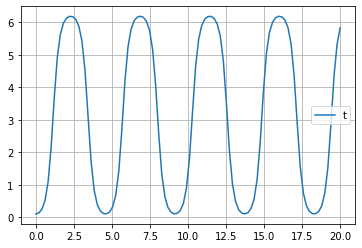

In [2]:
# State Space Representation
def simple_state_space(y: list, t: float, g=9.81, L=1): # [theta, angular velocity]
    # System is time invariant, so it doesn't depend on t (timestep)
    theta, w = y
    dtheta = w
    dw = 3*g/(2*L)*np.sin(theta)
    return dtheta, dw

ts = np.linspace(0,20,100)

ys = odeint(simple_state_space, y0=(0.1, 0), t=ts) # Run simulation
thetas, ws = ys.T
ys = np.cos(thetas) # Peak of the rod

# Plot the numerical solution
plt.grid()
plt.plot(ts, thetas)
plt.legend('theta')
plt.show()

### Control
When the wheel is driven by a motor, an extra torque is added to the system. This torque will depend on how large the angle is:
$$mg\frac{L}{2}sin\theta - M(\theta)=\frac{1}{3}mL^2\frac{d^2 \theta}{dt^2}$$

$M$ will attempt to minimize the error ($\theta$) in the fastest and most stable way possible. Using the state-space representation, we get:

$$\frac{d}{dt}\binom{\theta}{w}=\binom{w}{\frac{3g}{2L}sin\theta - \frac{3}{mL}M(\theta)}$$


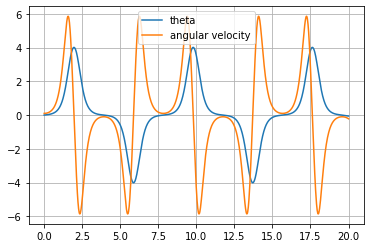

In [3]:
# Expample control loop (simply proportional to error)
def M(theta, a=1):
    return a*theta

# State Space Representation
def system_ode(y: list, t: float, g=9.81, L=1, m=1): # [theta, angular velocity]
    # System is time invariant, so it doesn't depend on t (timestep)
    theta, w = y
    dtheta = w
    dw = 3*g/(2*L)*np.sin(theta) - 3/(m*L)*M(theta)
    return dtheta, dw

ts = np.linspace(0,20,1000)

ys = odeint(system_ode, y0=(0, 0.1), t=ts) # Resultant thetas
thetas, ws = ys.T

# Plot the numerical solution
plt.grid()
plt.plot(ts, ys)
plt.legend(('theta', 'angular velocity'))
plt.show()

$M$ will most likely be implemented using a PID controller. The generic formula for PID is:
$$M(\theta)=K_{p}\theta+K_{i}\int_{0}^{t}\theta(\tau)d\tau\ +\ K_{d}\frac{d\theta}{dt}$$

And thus, the final system is:

$$\frac{d}{dt}\binom{\theta}{w}=\binom{w}{\frac{3g}{2L}sin\theta - \frac{3}{mL}(K_{p}\theta+K_{i}\int_{0}^{t}\theta(\tau)d\tau\ +\ K_{d}\frac{d\theta}{dt})}$$

Checkout `sim.py` for the implementation of this system.